# Introduction to PySpark and RDD

The massive amount of data today bring new challenges to data scientists. For instance, many machine learning algorithms need to be distrbuted in order to get things done at scale. Therefore, it is important for data scientist to grasp big data analytic skills . 

Apache Spark is such a fast and open-source cluster computing system that is well-suited for doing large-scale data analytics. This tutorial will introduce how to use Spark in Python by using the pyspark library. Especially, we will focus on Resilient Distributed Dataset (RDD), which is the basic abstraction in Spark to work with data. RDD is the underlying infrastrcuture that allows Spark to run so fast. And many libraries in Spark, like MLib, are built on top of RDD. So it is a good choice to start from RDD.

For more information, you can look up the details in [Spark's Python API](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD)

The following topics will be covered in this tutorial:

* [Installing the libraries](#Installing-the-libraries)
* [Creating RDD](#Creating-RDD)
* [RDD Tansformation and Action](#RDD-Transformation-and-Action)
* [Pair RDD](#Pair-RDD)
* [Application Samples](#Application-Samples)
    * [wordcount Sample](#1.WordCount-Sample)
    * [PCA Sample](#2.PCA-Sample)
* [Summary and Resources](#Summary-and-Resources)

## Installing the libraries


Using pip:

```python
pip install pyspark
```

If you work on Anaconda, you may consider using conda:
```python
conda install -c conda-forge pyspark
```

Note that if you have both python2 and python3 in your computer, you may encounter problem when using spark. Then, you need to modify the environment variables ``` PYSAPRK_PYTHON ```. For instance, I use the following code to modify it:

```python
import os
os.environ['PYSPARK_PYTHON'] = '/Users/qy/anaconda/bin/python'
```
The path will differ on your machines. Can search on internet if you need more help.

Make sure the following code works:

In [1]:
from pyspark import SparkContext

## Creating RDD

RDD enables operations done in parrallel. We can use SparkContext to create RDD. SparkContext tells Spark how and where to access a cluster. 

*Note that only one SparkContext is allowed at a time.If you have a running SparkContext, stop it before creating a new one.*

In [2]:
#sc.stop()
sc = SparkContext()

RDD can be constructed in several ways:

* parallelize existing Python lists
* transform an existing RDD (later)
* from files (later)

In [3]:
# parallelize python lists
numList = [1,11,5,7,8,22,51,52,9]
numsRDD = sc.parallelize(numList, numSlices = 4)
# Print out the type of numsRDD
print (type(numsRDD))

<class 'pyspark.rdd.RDD'>


The ```numSlices``` refers to the number of partitions that you would like the RDD split into. Default value is used if unspecified.

An RDD is an distributed collection of objects. If you have no idea what "distrbuted" or "parallel" means, you can think it as splitting and storing the data in different machines and the ```numSlices``` is similar to the number of machines. Then calculations are done in different machines seperately, so that each machine only deals with a small amount of data. Finally, the result of each machine is aggregated in a certain way to get the final output.


To create RDD from files, use `sc.textFile()` (example in last part of the tutorial):

```python
textFile = sc.textFile('xx.txt')
```

## RDD Transformation and Action

After constructing RDD, we can do operations on it.  

There are two primary types of operations:
* transformations
* actions

### Transformations

Transformation creating a new RDD by performing some operations on an existing RDD. 

Transformation Example                          |Result
----------                               |-------
`filter(func)`           |Return a new RDD containing only the elements that satisfy a predicate.
`map(func)`                   |Return a new RDD by applying a function to each element of this RDD.
`flatMap(func)`           |Same operation as map(), but flatten sequence
`distinct()`                             |Remove duplicates in RDD
`sortBy(keyfunc, ascending=True)`   |Sorts this RDD by the given keyfunc
 
 Note that transformations are **lazy**, which means that transformation on RDD is not executed until there is an action run on it. Spark just remembers the 'recipe' or transformations applied on RDD, but not compute it right away. This lazy evaluation can allow Spark to optimize the required colculations later.
 
### Actions
Once you have the 'recipe' of transformations ready, you will need to execute them by calling an action. 

Action Example                       |Result
----------                             |-------
`collect()`                            |Convert RDD to an array and return the array 
`take(n)`                              |Retun first n elements of RDD in array
`sum()`                                |Find element sum 
`mean()`                               |Find element mean 
`stdev()`                              |Find element deviation 
`reduce(func)`                         |Aggregate elements using function func. (Can view it as to aggregate results from diffirent machines.)


Additional information can be found in [Spark's Transformations API](https://spark.apache.org/docs/2.2.0/rdd-programming-guide.html#transformations) and [Spark's Actions API](https://spark.apache.org/docs/2.2.0/rdd-programming-guide.html#actions).




#### Examples:

*Lambda function* is often used to restrict the operation command in a single expression. If you do not know lambda functions before, you can refer to [here](https://docs.python.org/2/tutorial/controlflow.html#lambda-expressions). 

In [4]:
# squared each element
numsRDD.map(lambda x: x**2)

PythonRDD[1] at RDD at PythonRDD.scala:48

Lazy evaluation means it is not executed yet. In order to get the result, use appropriate actions.

In [5]:
numsRDD.collect()

[1, 11, 5, 7, 8, 22, 51, 52, 9]

In [6]:
numsRDD.map(lambda x: x**2).collect()

[1, 121, 25, 49, 64, 484, 2601, 2704, 81]

In [7]:
numsRDD.map(lambda x: x**2).take(3) # take the first 3

[1, 121, 25]

Several transformations can be chained together. 

For instance, if we want to split data first, and then return only people less than 40 years old:

In [8]:
rdd2 = sc.parallelize(['Ming,China,34','Michael,U.S.,50','Ivy,Canada,18','Coco,Mexico,25'])
rdd2.collect()

['Ming,China,34', 'Michael,U.S.,50', 'Ivy,Canada,18', 'Coco,Mexico,25']

In [9]:
rdd2.map(lambda x: x.split(',')).\
     filter(lambda x:  int(x[2]) <40).\
     map(lambda x:','.join(x)).\
     collect()

['Ming,China,34', 'Ivy,Canada,18', 'Coco,Mexico,25']

Besides lambda functions, other functions can also be passed.

In [10]:
def parse_filter(line):
    elems = line.split(",")
    if (int(elems[2])<40):
        return True
    else:
        return False
rdd2.filter(parse_filter).collect()

['Ming,China,34', 'Ivy,Canada,18', 'Coco,Mexico,25']

#### `map()` vs ` flatMap()`

In [11]:
rdd2.map(lambda x: x.split(',')).collect()

[['Ming', 'China', '34'],
 ['Michael', 'U.S.', '50'],
 ['Ivy', 'Canada', '18'],
 ['Coco', 'Mexico', '25']]

In [12]:
rdd2.flatMap(lambda x: x.split(',')).collect()

['Ming',
 'China',
 '34',
 'Michael',
 'U.S.',
 '50',
 'Ivy',
 'Canada',
 '18',
 'Coco',
 'Mexico',
 '25']

#### `reduce(func) `

The `func` here takes two arguments and returns only one result. It requires the operation to be commutative (e.g., a × b = b × a) and associative (e.g., ( a × b ) × c = a × ( b × c ).), so that it can be computed correctly in parallel.

In [13]:
rdd3 = sc.parallelize([1,3,5,7])
rdd3.reduce(lambda a,b: a*b)

105

In [14]:
print("sum is",rdd3.reduce(lambda a,b: a+b))

sum is 16


In [15]:
print("mean value is:",rdd3.reduce(lambda a,b:a+b)/rdd3.count())

mean value is: 4.0


For some operations, like sum,mean,standard deviation, instead of writing functions by yourself, there are existing actions() for you to use:

In [16]:
print("sum is",rdd3.sum())
print("mean value is",rdd3.mean())
print("standard deviation is",rdd3.stdev())

sum is 16
mean value is 4.0
standard deviation is 2.23606797749979


## Pair RDD

Spark also supports Key-Value pairs.

A pair RDD is an RDD where each element is a pair tuple (k, v) where k is the key and v is the value. 

For instance, use the `numsRDD` we create before, we can construct a pair RDD with each pair is (num, 'even' or 'odd') for each number in the RDD. 

In [17]:
pairs = numsRDD.map(lambda n: (n,'even') if n%2 ==0 else (n,'odd'))
pairs.collect()

[(1, 'odd'),
 (11, 'odd'),
 (5, 'odd'),
 (7, 'odd'),
 (8, 'even'),
 (22, 'even'),
 (51, 'odd'),
 (52, 'even'),
 (9, 'odd')]

There are some specific transformations for Key-Value paris:

Transformation Example                          |Result
----------                               |-------
`reduceByKey(func)`           |	Returns a RDD of (K, V) pairs where the values for each key are aggregated using the given reduce function func. 
`sortByKey()`                   |Returns a RDD of (K, V) pairs sorted by keys.
`groupByKey()`           |Returns a RDD of (K,Iterable V ) pairs.

Additional information can be found in [Spark's Transformations API](http://spark.apache.org/docs/latest/rdd-programming-guide.html#transformations
 ).

#### `sortByKey()`

In [18]:
print("Sort by key on the pairs:")
pairs.sortByKey().collect()

Sort by key on the pairs:


[(1, 'odd'),
 (5, 'odd'),
 (7, 'odd'),
 (8, 'even'),
 (9, 'odd'),
 (11, 'odd'),
 (22, 'even'),
 (51, 'odd'),
 (52, 'even')]

Suppose the key and value is exchanged, now you want to sort by value. Can use `sortBy()`.

In [19]:
# x[1] refers to value in (K,V) pair
pairs.map(lambda x: (x[1],x[0])).sortBy(lambda x: x[1],ascending = False).collect()

[('even', 52),
 ('odd', 51),
 ('even', 22),
 ('odd', 11),
 ('odd', 9),
 ('even', 8),
 ('odd', 7),
 ('odd', 5),
 ('odd', 1)]

Now, we want to know how many even and odd numbers are there in numsRDD.

**`reduceByKey()`**

One way is to use `reduceByKey() ` to do it by first converting each pair to the form of ('even' or 'odd',1).

In [20]:
pairs.map(lambda x:(x[1],1)).collect()

[('odd', 1),
 ('odd', 1),
 ('odd', 1),
 ('odd', 1),
 ('even', 1),
 ('even', 1),
 ('odd', 1),
 ('even', 1),
 ('odd', 1)]

In [21]:
pairs.map(lambda x:(x[1],1)). \
      reduceByKey(lambda a,b: a+b).\
      collect()

[('even', 3), ('odd', 6)]


#### `groupByKey()`
Another way to do it is to exchange key and value, and then use `groupByKey()` function to group all the numbers by 'odd' and 'even'. Finally, count the number of numbers within each group.

In [22]:
# x[1] is the value, x[0] is the key, exchange them first
pairs.map(lambda x:(x[1],x[0])). \
      groupByKey().\
      map(lambda x: (x[0],len(x[1]))).\
      collect()
# afrer groupByKey(), x[0] is the key, x[1] is the iterable

[('even', 3), ('odd', 6)]

*Note: Be careful using **groupByKey()**! *

To understand it, we need to learn more about spark.

#### More On Spark

<img src="https://raw.githubusercontent.com/qyuan210/15688/master/Screen%20Shot%202018-03-24%20at%205.24.56%20PM.png" width=500/>

As showed in the picture, Spark has one Driver that communicates with many distributed Workers (executors). 

* The driver is the process where the main method runs. It generates tasks to be done and schedules the tasks to the workers.

* The workers run individual tasks independently. RDDs are distributed across workers. The transformations and actions are also done in each worker. Only the final results of the action aggregating from each worker is sent back to the driver.

Then, why groupByKey() is bad? 

1. It involves a lot of data movement across the network (across the workers), which is time-costly. For instance, for the key "cat", maybe one ('cat',1) is in worker1, and the other ('even',1) are in worker2, then, in order to group them together, it requires data to move on the network.
2. The groupByKey() will return iterable, which may be very large and could exhaust available memory in a worker. Remember, the data size is very huge, and that is why we choose to distribute.


## Application Samples

Now that you have learned a lot about RDDs,let's apply it.

### 1.WordCount Sample

Download data from [here](
https://raw.githubusercontent.com/qyuan210/15688/master/tutorialdata.txthttps://raw.githubusercontent.com/qyuan210/15688/master/tutorialdata.txt). Name it as "tutorialdata.txt" and put it under the same folder as this tutorial.

The data used is modified from [Complete Works of William Shakespeare](http://www.gutenberg.org/ebooks/100). And we will implement Spark and RDD to do wordcount task for this data. 

As mentioned in previous part, we can use `SparkContext.textFile()` method to convert a text file into an RDD.


In [23]:
data = sc.textFile('tutorialdata.txt')
data

tutorialdata.txt MapPartitionsRDD[45] at textFile at NativeMethodAccessorImpl.java:0

In [24]:
print("Take a look at first 20 elements in RDD. ")
data.take(20)

Take a look at first 20 elements in RDD. 


['                    1',
 '',
 'From fairest creatures we desire increase,',
 'That thereby beauty’s rose might never die,',
 'But as the riper should by time decease,',
 'His tender heir might bear his memory:',
 'But thou contracted to thine own bright eyes,',
 'Feed’st thy light’s flame with self-substantial fuel,',
 'Making a famine where abundance lies,',
 'Thy self thy foe, to thy sweet self too cruel:',
 'Thou that art now the world’s fresh ornament,',
 'And only herald to the gaudy spring,',
 'Within thine own bud buriest thy content,',
 'And, tender churl, mak’st waste in niggarding:',
 '  Pity the world, or else this glutton be,',
 '  To eat the world’s due, by the grave and thee.',
 '',
 '                    2',
 '',
 'When forty winters shall besiege thy brow,']

Each line in the txt file is viewed as one element. And notice that there are punctuations, empty lines and numbers in the file. For the purpose of doing wordcount, some data preprocess is needed. 

#### cleanText
In the `cleanText` function:
1. all text are transformed into lowercase
2. only characters are kept (remove punctuations, numbers,etc.)
3. finally,the learning and trailing spaces are also removed


In [25]:
import re
def cleanText(text):
    result = re.sub('[^a-z\s]+', '', text.strip().lower())
    return result.strip()

data.map(lambda x:cleanText(x)).take(5)

['',
 '',
 'from fairest creatures we desire increase',
 'that thereby beautys rose might never die',
 'but as the riper should by time decease']

#### remove empty lines

In [26]:
print("number of lines before:",data.map(lambda x:cleanText(x)).count())
cleanData = data.map(lambda x:cleanText(x)).filter(lambda x: x!='')
print("numer of lines after:",cleanData.count())
cleanData.take(5)

number of lines before: 134748
numer of lines after: 125511


['from fairest creatures we desire increase',
 'that thereby beautys rose might never die',
 'but as the riper should by time decease',
 'his tender heir might bear his memory',
 'but thou contracted to thine own bright eyes']

#### wordcount
Split each line to get word presentation. Since we want to do wordcount based on the whole file, instead of eachline, we need to use `flatMap()` instead of `map()`. 

In [27]:
tokenData = cleanData.flatMap(lambda x: x.split())
print("number of words in total:",tokenData.count())
tokenData.take(20)

number of words in total: 957709


['from',
 'fairest',
 'creatures',
 'we',
 'desire',
 'increase',
 'that',
 'thereby',
 'beautys',
 'rose',
 'might',
 'never',
 'die',
 'but',
 'as',
 'the',
 'riper',
 'should',
 'by',
 'time']

Now, we get 957709 words, how to apply Spark and RDD to do word count?

We can do similar thing as counting number of odd and even words in previous part. Recall that there are disadvantages of `groupByKey()`, use `reduceByKey()` here.

In [28]:
wordCountRDD = tokenData.map(lambda w: (w,1)).reduceByKey(lambda a,b: a+b)

In [29]:
print("The number of elements in wordCountRDD is equal to the number of unique words in the text:")
wordCountRDD.count()

The number of elements in wordCountRDD is equal to the number of unique words in the text:


31055

In [30]:
tokenData.distinct().count()

31055

In [31]:
wordCountRDD.take(5)

[('fairest', 46),
 ('creatures', 49),
 ('we', 3554),
 ('increase', 32),
 ('thereby', 27)]

`takeOrdered(n, [ordering])` is an action that returns the first n elements of the RDD using either their natural order or a custom comparator in ordering parameter. 

We can use this action to find the top20 words that occur most frequently in the text.

In [32]:
wordCountRDD.takeOrdered(20, key = lambda x: -x[1])

[('the', 29942),
 ('and', 28314),
 ('i', 21848),
 ('to', 20882),
 ('of', 18774),
 ('a', 15964),
 ('you', 14433),
 ('my', 13191),
 ('in', 12013),
 ('that', 11780),
 ('is', 9707),
 ('not', 9064),
 ('with', 8518),
 ('me', 8266),
 ('for', 8180),
 ('it', 8167),
 ('his', 7574),
 ('be', 7363),
 ('this', 7175),
 ('your', 7075)]

Not surprisingly, all of them are coomon stopwords!

### 2.PCA Sample

In this sample, we will generate PCA from scratch, which is a dimension reduction method. You can refer to [here](https://en.wikipedia.org/wiki/Principal_component_analysis) to learn PCA. And in this tutorial, PCA is computed using [the covariance method](https://en.wikipedia.org/wiki/Principal_component_analysis#Computing_PCA_using_the_covariance_method).

The data used can be an example of PCA [here](http://setosa.io/ev/principal-component-analysis/).

In [33]:
import numpy as np

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

In [35]:
# construct and view the dataset
food_data = np.array([[105, 103, 103, 66],
                      [245, 227, 242, 267],
                      [685, 803, 750, 586],
                      [147, 160, 122, 93],
                      [193, 235, 184, 209], 
                      [156, 175, 147, 139],
                      [720, 874, 566, 1033],
                      [253, 265, 171, 143],
                      [488, 570, 418, 355],
                      [198, 203, 220, 187],
                      [360, 365, 337, 334],
                      [1102, 1137, 957, 674],
                      [1472, 1582, 1462, 1494],
                      [57, 73, 53, 47],
                      [1374, 1256, 1572, 1506],
                      [375, 475, 458, 135],
                      [54, 64, 62, 41]])
row_labels = ['Cheese',
              'Carcass meat',
              'Other meat',
              'Fish',
              'Fats and oils',
              'Sugars',
              'Fresh potatoes',
              'Fresh Veg',
              'Other Veg',
              'Processed potatoes',
              'Processed Veg',
              'Fresh fruit',
              'Cereals',
              'Beverages',
              'Soft drinks',
              'Alcoholic drinks',
              'Confectionary']

column_labels = ['England', 'Wales', 'Scotland', 'N Ireland']

first_column_width = 20
other_columns_width = 15

# print header
print("".ljust(first_column_width), end = '') #by default, end is "\n"

for column_label in column_labels:
    print(column_label.rjust(other_columns_width), end='')
print()

# print each row in the numpy array with a column label
for row_label, row in zip(row_labels, food_data):
    print(row_label.ljust(first_column_width), end='')
    print("".join([("%d" % x).rjust(other_columns_width) for x in row]))
    
    
print("\nNote: each column is a data point.")

                            England          Wales       Scotland      N Ireland
Cheese                          105            103            103             66
Carcass meat                    245            227            242            267
Other meat                      685            803            750            586
Fish                            147            160            122             93
Fats and oils                   193            235            184            209
Sugars                          156            175            147            139
Fresh potatoes                  720            874            566           1033
Fresh Veg                       253            265            171            143
Other Veg                       488            570            418            355
Processed potatoes              198            203            220            187
Processed Veg                   360            365            337            334
Fresh fruit                 

The table shows some interesting variations across different food types, but overall differences aren't so notable. Let's see if PCA can eliminate dimensions to emphasize how countries differ.

In [36]:
foodRDD = sc.parallelize(food_data.T)

#### a. recenter data
Subtract mean from each column. The new RDD has zero mean for each column.

In [37]:
mean = foodRDD.sum()/foodRDD.count()
zeromeanRDD = foodRDD.map(lambda x: x - mean)

print (mean)
print (foodRDD.take(1))
print (zeromeanRDD.take(1))

[  94.25  245.25  706.    130.5   205.25  154.25  798.25  208.    457.75
  202.    349.    967.5  1502.5    57.5  1427.    360.75   55.25]
[array([ 105,  245,  685,  147,  193,  156,  720,  253,  488,  198,  360,
       1102, 1472,   57, 1374,  375,   54])]
[array([ 10.75,  -0.25, -21.  ,  16.5 , -12.25,   1.75, -78.25,  45.  ,
        30.25,  -4.  ,  11.  , 134.5 , -30.5 ,  -0.5 , -53.  ,  14.25,
        -1.25])]


#### b.compute covariance matrix

If we define $\scriptsize \mathbf{X} \in \mathbb{R}^{n \times d}$ as the zero mean data matrix, then the covariance matrix is defined as: $$ \mathbf{C}_{\mathbf X} = \frac{1}{n} \mathbf{X}^\top \mathbf{X} \,.$$  

Note that for RDD, data and computation is distributed to different workers. To compute this matrix, first compute the outer product of each data point, which can be done independently in each worker. Then,add together these outer products from every worker, and divide by the number of data points. 
 


In [38]:
Cov = zeromeanRDD.map(lambda x: np.outer(x,x)).sum()/zeromeanRDD.count()
print(Cov.shape)

(17, 17)


#### c.eigen decomposition

We can perform an eigendecomposition of the covariance matrix to find its eigenvalues and eigenvectors. The $\scriptsize d $ eigenvectors of the covariance matrix give us the directions of maximal variance, and are called the "principal components."  The associated eigenvalues are the variances in these directions. 
 
Function from `numpy.linalg` called [eigh](http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eigh.html) can be used to perform the eigendecomposition. 

In [39]:
from numpy.linalg import eigh

eigVals, eigVecs = eigh(Cov)

#reorder the eigvectors and eigvalues by descending of eigen values
inds = np.argsort(-eigVals)
eigVals = eigVals[inds]
eigVecs = eigVecs[:, inds]

TopVecs = eigVecs[:,0:1]


print ('topComponents: \n{0}'.format(TopVecs))
print ('\neigenvalues: \n{0}'.format(eigVals))


topComponents: 
[[-0.05695538]
 [ 0.04792763]
 [-0.25891666]
 [-0.08441498]
 [-0.00519362]
 [-0.03762098]
 [ 0.40140206]
 [-0.15184994]
 [-0.24359373]
 [-0.02688623]
 [-0.03648827]
 [-0.6326409 ]
 [-0.04770286]
 [-0.02618776]
 [ 0.23224414]
 [-0.46396817]
 [-0.0296502 ]]

eigenvalues: 
[ 7.88050093e+04  3.39462187e+04  4.09327202e+03  1.54680383e-11
  2.53115832e-12  6.84274882e-13  3.50730576e-13  1.20176942e-13
  7.15829818e-14  1.50330576e-14 -2.48950215e-15 -6.55224003e-15
 -3.79206125e-14 -1.34069089e-13 -6.33203554e-13 -2.53821578e-12
 -1.37453208e-11]


#### c. project data onto new dimensions

In [40]:
print("reduce to 1 dimension:")
foodRDD.map(lambda x:x.dot(TopVecs)).take(5)

reduce to 1 dimension:


[array([-702.98504825]),
 array([-798.52104371]),
 array([-649.86123507]),
 array([-80.60025725])]

In [41]:
print("reduce to 2 dimension:")
zeromeanRDD.map(lambda x:x.dot(eigVecs[:,:2])).take(5)

reduce to 2 dimension:


[array([-144.99315218,   -2.53299944]),
 array([-240.52914764, -224.64692488]),
 array([-91.869339  , 286.08178613]),
 array([477.39163882, -58.90186182])]

#### pca function

Wrap up the steps above to a single `pca` function.

In [42]:
def pca(data, k = 2):
    
    mean = data.sum()/data.count()
    zeromeanRDD = data.map(lambda x: x - mean)
    Cov = zeromeanRDD.map(lambda x: np.outer(x,x)).sum()/zeromeanRDD.count()
    
    eigVals, eigVecs = eigh(Cov)
    inds = np.argsort(-eigVals)
    eigVals = eigVals[inds]
    #each column in eigVecs is an eigen vector
    eigVecs = eigVecs[:, inds]
    kVecs = eigVecs[:,0:k]
    
   
    projections = zeromeanRDD.map(lambda x:x.dot(kVecs))
    
    # Return the `k` principal components, 'k' dim projections, and all eigenvalues)
    return (kVecs, projections,eigVals)

In [43]:
# Run pca on with k = 2
KComponents, projection, eigenvalues = pca(foodRDD)

print ('First 2 Components: \n{0}'.format(KComponents))
print ('\nprojection to 2 dimensions: \n{0}'
       .format('\n'.join(map(str, projection.collect()))))
print ('\neigenvalues: \n{0}'.format(eigenvalues))


First 2 Components: 
[[-0.05695538  0.01601285]
 [ 0.04792763  0.01391582]
 [-0.25891666 -0.01533114]
 [-0.08441498 -0.05075495]
 [-0.00519362 -0.09538866]
 [-0.03762098 -0.0430217 ]
 [ 0.40140206 -0.71501708]
 [-0.15184994 -0.14490027]
 [-0.24359373 -0.22545092]
 [-0.02688623  0.04285076]
 [-0.03648827 -0.0454518 ]
 [-0.6326409  -0.17774074]
 [-0.04770286 -0.21259968]
 [-0.02618776 -0.03056054]
 [ 0.23224414  0.55512431]
 [-0.46396817  0.11353652]
 [-0.0296502   0.00594992]]

projection to 2 dimensions: 
[-144.99315218   -2.53299944]
[-240.52914764 -224.64692488]
[-91.869339   286.08178613]
[477.39163882 -58.90186182]

eigenvalues: 
[ 7.88050093e+04  3.39462187e+04  4.09327202e+03  1.54680383e-11
  2.53115832e-12  6.84274882e-13  3.50730576e-13  1.20176942e-13
  7.15829818e-14  1.50330576e-14 -2.48950215e-15 -6.55224003e-15
 -3.79206125e-14 -1.34069089e-13 -6.33203554e-13 -2.53821578e-12
 -1.37453208e-11]


#### data visualization

* data along the first principal component

In [44]:
P = projection.collect()
x1 = [a[0] for a in P]
x2 = [a[1] for a in P]

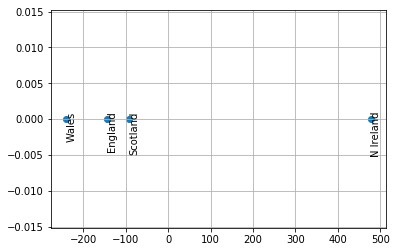

In [45]:
y_axis_all_zeros = np.zeros(len(x1))
plt.scatter(x1, y_axis_all_zeros)
for idx in range(food_data.T.shape[0]):
    plt.annotate(column_labels[idx], (x1[idx], y_axis_all_zeros[idx]),rotation = 90)
plt.grid()
plt.show()

* data projected to the first  and second principal components

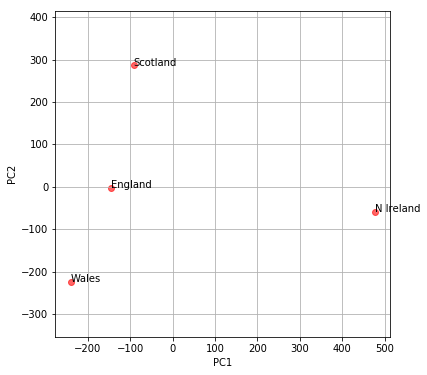

In [46]:
plt.figure(figsize = (6,6))
plt.scatter(x1,x2, alpha = 0.6,c = 'red')
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.axis('equal')

for idx in range(food_data.T.shape[0]):
    plt.annotate(column_labels[idx], (x1[idx], x2[idx]))
    
plt.grid()
plt.show()

We can see that Northern Ireland is a major outlier.

#### Variance explained

Finally, let's quantify how much of the variance is being captured by PCA.

In [47]:
def varianceExplained(data, k=1):
    
    components, projections, eigenvalues = pca(data,k)
    
    #return the percentage of variance explained by the top `k` eigenvectors.
    return eigenvalues[0:k].sum()/eigenvalues.sum()

variance1 = varianceExplained(foodRDD, 1)
variance2 = varianceExplained(foodRDD, 2)
variance3 = varianceExplained(foodRDD, 2)


print ('Percentage of variance explained by the first component of foodData: {0:.1f}%'
       .format(variance1 * 100))
print ('Percentage of variance explained by the top2 component of foodData: {0:.1f}%'
       .format(variance2 * 100))

Percentage of variance explained by the first component of foodData: 67.4%
Percentage of variance explained by the top2 component of foodData: 96.5%


We can see the top2 component explain more than 90% variance of data. PCA works well.

While this is just a mini dataset to help you understand, using Spark can really help in big data context becuase of its underlying infrastructure. Also, [pca](https://spark.apache.org/docs/2.2.0/mllib-dimensionality-reduction.html#principal-component-analysis-pca) in pyspark.mllib can be used directly. You can explore it by yourself.

## Summary and Resources

This tutorial covered just the basic concepts and operations of RDD. There are much more things in RDD and Spark.You may find following links helpful for further studies:

1. PySpark API: http://spark.apache.org/docs/latest/api/python/
2. PCA analysis: http://setosa.io/ev/principal-component-analysis/
3. Learning Spark: http://shop.oreilly.com/product/0636920028512.do
4. Advanced Analytics with Spark: http://shop.oreilly.com/product/0636920035091.do
5. PySpark CheatSheet: https://www.datacamp.com/community/blog/pyspark-cheat-sheet-python
6. Python Basics: http://ai.berkeley.edu/tutorial.html#PythonBasics